# Predicting High-Priced Rental Apartments in the USA  
### Milestone 1 – Group_26

---

In [1]:
# Install needed packages if not available
#!pip install ucimlrepo seaborn scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandera as pa

from ucimlrepo import fetch_ucirepo
from pandera import Column, Check, DataFrameSchema
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, ConfusionMatrixDisplay
)


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)


## **Summary**

This project investigates whether it is possible to predict when an apartment listing in the United States is **high-priced relative to other listings in the same state**. Using the *Apartment for Rent Classified* dataset from the UCI Machine Learning Repository, we defined a binary target indicating whether each listing's price was above the state-level median. We developed a logistic regression model to classify listings as either high-priced or not. The final classifier achieved an accuracy of 0.7 on unseen data, indicating that it correctly predicts a listing as high-priced in most cases. 

The notebook includes:
- Data loading from the web  
- Data cleaning and wrangling  
- Exploratory data analysis  
- Visualizations  
- Classification modeling  
- Results, discussion, and conclusions  

## Introduction

Homeownership in the United States has become somewhat less attainable for many Americans due to increasing housing prices, rising mortage rates and other increases in the cost of living. As a result, according to recent surveys, around 84% of Gen Z adults report delaying major life milestones in order to afford a home, with many turning to long-term renting instead. Nearly 75% of Gen Z say they prefer renting to owning, which is important to note as this generation represents more than 20% of the U.S. population. Growing rental demand is driving new construction as developers across the country are expected to add more than 500,000 new apartment units across the country.  

These trends lead us to wonder if apartment rental prices vary dramatically across the U.S. A price considered as “expensive” in Texas may be considered “cheap” in New York. As many Gen Z adults are relocating to higher-cost states and more than 75% of them rent, understanding these price differences is increasingly important. Additionally, rental prices are influenced by a variety of listing features. For example, apartments with more bedrooms or bathrooms are generally associated with higher-prices. Other features such as whether pets are allowed or whether the apartment includes additional fees, may also signal higher quality or prices. These features will be incorporated into our model to assess their impact on whether an apartment is classified as high-priced or not. To create a meaningful comparison across regions, we evaluated whether each apartment is **high-priced relative to the median rent within its own state**.

## Research Question

Can a machine learning algorithm accurately predict whether an apartment listing is high-priced relative to the median rental price in its state, using features such as square footage, number of bedrooms and bathrooms, and various listing attributes?

## Dataset

We use the **Apartment for Rent Classified** dataset from the UCI Machine Learning Repository. The dataset contains:
- 10,000+ apartment listings  
- Structural and listing details  
- Geographic information  
- Price and square footage  

---

# Data Cleaning & Wrangling

We prepared the dataset by:

1. Loading the data from the UCI ML Repository 
1. Selecting relevant columns  
2. Removing rows with missing or invalid values  
3. Computing the median rental price for each state  
4. Creating a binary target variable `high_price`

In [2]:
# Load dataset directly from the UCI ML Repository
apartment_ds = fetch_ucirepo(id=555)

df = apartment_ds.data.original.copy()

df.head()

/Users/shanzekhemani/miniforge3/envs/Group_26/lib/python3.12/site-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (0,5,6,12,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


,id,category,title,body,amenities,bathrooms,bedrooms,currency,fee,has_photo,...,price_display,price_type,square_feet,address,cityname,state,latitude,longitude,source,time
0,5668640009,housing/rent/apartment,One BR 507 & 509 Esplanade,"This unit is located at 507 & 509 Esplanade, R...",NaN,1,1,USD,No,Thumbnail,...,2195,Monthly,542,507 509 Esplanade,Redondo Beach,CA,33.8520,-118.3759,RentLingo,1.577360e+09
1,5668639818,housing/rent/apartment,Three BR 146 Lochview Drive,"This unit is located at 146 Lochview Drive, Ne...",NaN,1.5,3,USD,No,Thumbnail,...,1250,Monthly,1500,146 Lochview Dr,Newport News,VA,37.0867,-76.4941,RentLingo,1.577360e+09
2,5668639686,housing/rent/apartment,Three BR 3101 Morningside Drive,This unit is located at 3101 Morningside Drive...,NaN,2,3,USD,No,Thumbnail,...,1395,Monthly,1650,3101 Morningside Dr,Raleigh,NC,35.8230,-78.6438,RentLingo,1.577360e+09
3,5668639659,housing/rent/apartment,Two BR 209 Aegean Way,"This unit is located at 209 Aegean Way, Vacavi...",NaN,1,2,USD,No,Thumbnail,...,1600,Monthly,820,209 Aegean Way,Vacaville,CA,38.3622,-121.9712,RentLingo,1.577360e+09
4,5668639374,housing/rent/apartment,One BR 4805 Marquette NE,"This unit is located at 4805 Marquette NE, Alb...",NaN,1,1,USD,No,Thumbnail,...,975,Monthly,624,4805 Marquette NE,Albuquerque,NM,35.1038,-106.6110,RentLingo,1.577360e+09


In [3]:
cols_needed = [
    "price", "square_feet", "bathrooms", "bedrooms",
    "state", "pets_allowed", "fee", "has_photo"
]

df_subset = df[cols_needed].copy()

# Convert price and square_feet to numeric (coerce invalid values to NaN)
df_subset["price"] = pd.to_numeric(df_subset["price"], errors="coerce")
df_subset["square_feet"] = pd.to_numeric(df_subset["square_feet"], errors="coerce")

# Also convert bathrooms and bedrooms to numeric
df_subset["bathrooms"] = pd.to_numeric(df_subset["bathrooms"], errors="coerce")
df_subset["bedrooms"] = pd.to_numeric(df_subset["bedrooms"], errors="coerce")

# Remove non-positive or missing price/square_feet
df_subset = df_subset[
    (df_subset["price"] > 0) &
    (df_subset["square_feet"] > 0)
]

# Drop rows with missing values in other key areas
df_subset = df_subset.dropna(subset=cols_needed)

# Compute median price per state
state_medians = df_subset.groupby("state")["price"].median()
df_subset["state_median_price"] = df_subset["state"].map(state_medians)

# Remove duplicates 
df_subset = df_subset.drop_duplicates().reset_index(drop=True)

# Create binary target
df_subset["high_price"] = (df_subset["price"] > df_subset["state_median_price"]).astype(int)

df_subset.head()

,price,square_feet,bathrooms,bedrooms,state,pets_allowed,fee,has_photo,state_median_price,high_price
0,2195.0,542.0,1.0,1.0,CA,Cats,No,Thumbnail,2155.0,1
1,1250.0,1500.0,1.5,3.0,VA,"Cats,Dogs",No,Thumbnail,1398.0,0
2,1600.0,820.0,1.0,2.0,CA,"Cats,Dogs",No,Thumbnail,2155.0,0
3,975.0,624.0,1.0,1.0,NM,"Cats,Dogs",No,Thumbnail,1012.5,0
4,1250.0,965.0,1.5,2.0,NM,"Cats,Dogs",No,Thumbnail,1012.5,1


In [4]:
# Data Validation Checks

numeric_cols = ["price", "square_feet", "bathrooms", "bedrooms", "state_median_price"]

target = "high_price"
threshold = 0.9  # correlation threshold

allowed_states = [
    'CA','VA','NM','CO','WV','WA','TX','IL','MS','OR','FL','MO','PA','IA',
    'WI','NC','GA','OK','RI','NJ','IN','MD','OH','ND','NE','DC','AZ','MA',
    'MI','SC','ID','MN','KS','TN','UT','KY','SD','LA','AK','AR','AL','CT',
    'NY','NV','HI','WY','VT','NH','MT','DE','ME'
]

allowed_pets = ['Cats', 'Cats,Dogs', 'Dogs', 'Cats,Dogs,None']
allowed_fee = ['No', 'Yes']
allowed_has_photo = ['Thumbnail', 'Yes', 'No']

def check_no_outliers(df):
    has_outliers = False  

    for col in numeric_cols:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower = q1 - 1.5 * iqr
        upper = q3 + 1.5 * iqr
        
        outliers = df[(df[col] < lower) | (df[col] > upper)]
        if not outliers.empty:
            has_outliers = True
            print(f"Outliers detected in column '{col}':")
            print(outliers[[col]])
            print("-"*40)
    
    return not has_outliers  # True if no outliers, False otherwise

def check_categories(df):
    invalid_found = False  # track if any invalid category exists
    
    category_mapping = {
        "state": allowed_states,
        "pets_allowed": allowed_pets,
        "fee": allowed_fee,
        "has_photo": allowed_has_photo
    }
    
    for col, allowed in category_mapping.items():
        invalid_rows = df[~df[col].isin(allowed)]
        if not invalid_rows.empty:
            invalid_found = True
            print(f"Unexpected values in column '{col}':")
            print(invalid_rows[[col]])
            print("-"*40)
    
    return not invalid_found  # True if all categories valid, False otherwise

def check_target_distribution(df):
    # Only 0 or 1 allowed
    unique_vals = set(df["high_price"].unique())
    if not unique_vals.issubset({0, 1}):
        print(f"Unexpected target values found: {unique_vals}")
        return False
    
    # Check class balance
    ratio = df["high_price"].mean()  # proportion of 1s
    if ratio <= 0.05 or ratio >= 0.95:
        print(f"Target distribution is extremely imbalanced: {ratio:.2f} proportion of 1s")
        return False
    
    return True

result = check_target_distribution(df_subset)
print("Target distribution check passed?", result)

def check_corr_target(df):
    corr = df[numeric_cols + [target]].corr()[target].drop(target)
    return (abs(corr) < threshold).all()

def check_corr_feats(df):
    for i in range(len(numeric_cols)):
        for j in range(i + 1, len(numeric_cols)):
            corr = df[numeric_cols[i]].corr(df[numeric_cols[j]])
            if abs(corr) >= threshold:
                return False
    return True

schema = DataFrameSchema(
    {
        "price": Column(pa.Float, nullable=False,
            checks=[Check.greater_than(0),
                    Check(lambda s: s.isna().mean() <= 0.05)]),

        "square_feet": Column(pa.Float, nullable=False,
            checks=[Check.greater_than(0),
                    Check(lambda s: s.isna().mean() <= 0.05)]),

        "bathrooms": Column(pa.Float, nullable=False,
            checks=[Check.greater_than_or_equal_to(0),
                    Check(lambda s: s.isna().mean() <= 0.05)]),

        "bedrooms": Column(pa.Float, nullable=False,
            checks=[Check.greater_than_or_equal_to(0),
                    Check(lambda s: s.isna().mean() <= 0.05)]),

        "state": Column(pa.String, nullable=False,
            checks=[Check.isin(allowed_states),
                    Check.str_length(min_value=1)]),

        "pets_allowed": Column(pa.String, nullable=True,
            checks=[Check.isin(allowed_pets)]),

        "fee": Column(pa.String, nullable=True,
            checks=[Check.isin(allowed_fee)]),

        "has_photo": Column(pa.String, nullable=False,
            checks=[Check.isin(allowed_has_photo)]),

        "state_median_price": Column(pa.Float, nullable=False,
            checks=[Check.greater_than(0),
                    Check(lambda s: s.isna().mean() <= 0.05)]),

        "high_price": Column(pa.Int, nullable=False,
            checks=[Check.isin([0, 1])]),
    },

    checks=[
        Check(lambda df: df.duplicated().sum() == 0, error="Duplicate rows detected"),
        Check(lambda df: ~df.isna().all(axis=1)),
        Check(check_no_outliers, error="Outliers detected in numeric columns."),
        Check(check_categories, error="Unexpected categorical values."),
        Check(check_target_distribution, error="Target variable distribution is anomalous"),
        Check(check_corr_target, error="Anomalous correlation between target and features."),
        Check(check_corr_feats, error="Anomalous correlation between features")
    ])

try:
    validated_df = schema.validate(df_subset, lazy=True)
    print("All checks passed!")
except pa.errors.SchemaErrors as e:
    print("Some checks failed:")
    print(e.failure_cases)

Target distribution check passed? True
Outliers detected in column 'price':
        price
13     3250.0
20     4950.0
27     3580.0
62     3200.0
63     3399.0
...       ...
35521  3140.0
35603  2902.0
35638  3275.0
35649  3850.0
35666  3002.0

[1713 rows x 1 columns]
----------------------------------------
Outliers detected in column 'square_feet':
       square_feet
27          2100.0
56          1850.0
63          1721.0
64          2598.0
65          2200.0
...            ...
35369       2756.0
35387       2196.0
35392       2080.0
35470       2160.0
35652       1900.0

[846 rows x 1 columns]
----------------------------------------
Outliers detected in column 'bathrooms':
       bathrooms
636          4.5
748          4.0
1014         4.0
1314         5.0
1324         4.5
1452         4.0
1547         4.0
1574         4.0
1692         4.0
1812         4.0
1835         5.0
1840         4.0
1876         4.0
2029         4.0
2130         7.0
2180         4.0
2740         4.5
2870   

/Users/shanzekhemani/miniforge3/envs/Group_26/lib/python3.12/site-packages/pandera/_pandas_deprecated.py:146: FutureWarning: Importing pandas-specific classes and functions from the
top-level pandera module will be **removed in a future version of pandera**.
If you're using pandera to validate pandas objects, we highly recommend updating
your import:

```
# old import
import pandera as pa

# new import
import pandera.pandas as pa
```

If you're using pandera to validate objects from other compatible libraries
like pyspark or polars, see the supported libraries section of the documentation
for more information on how to import pandera:

https://pandera.readthedocs.io/en/stable/supported_libraries.html

To disable this warning, set the environment variable:

```
export DISABLE_PANDERA_IMPORT_WARNING=True
```

  warnings.warn(_future_warning, FutureWarning)


# Exploratory Data Analysis (EDA)

We explored:

- Summary statistics  
- Class balance  
- Price distribution  
- Relationship between size and price  


In [7]:
df_subset[["price", "square_feet", "bathrooms"]].describe()

,price,square_feet,bathrooms
count,35700.000000,35700.000000,35700.000000
mean,1487.928235,940.632157,1.440294
std,722.414581,338.539094,0.533467
min,285.000000,200.000000,1.000000
25%,1025.000000,720.750000,1.000000
50%,1327.000000,897.000000,1.000000
75%,1745.000000,1105.000000,2.000000
max,19500.000000,12000.000000,7.000000


In [8]:
df_subset["high_price"].value_counts(normalize=True)

high_price
1    0.510728
0    0.489272
Name: proportion, dtype: float64

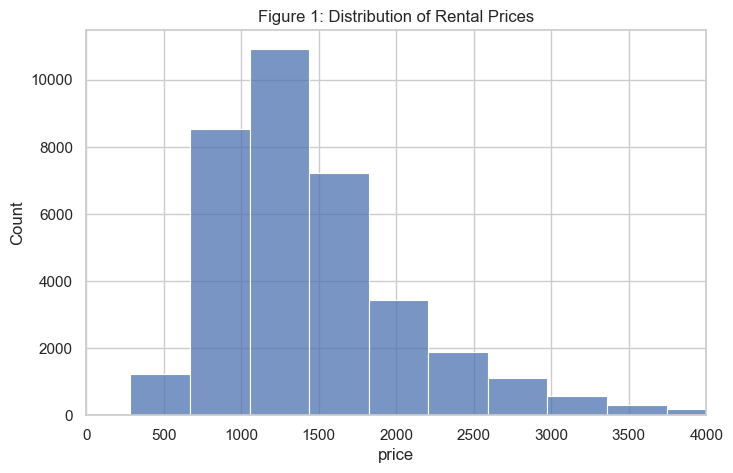

In [9]:
sns.histplot(df_subset["price"], bins=50)
plt.xlim(0, df_subset["price"].quantile(0.99))
plt.title("Figure 1: Distribution of Rental Prices")
plt.show()

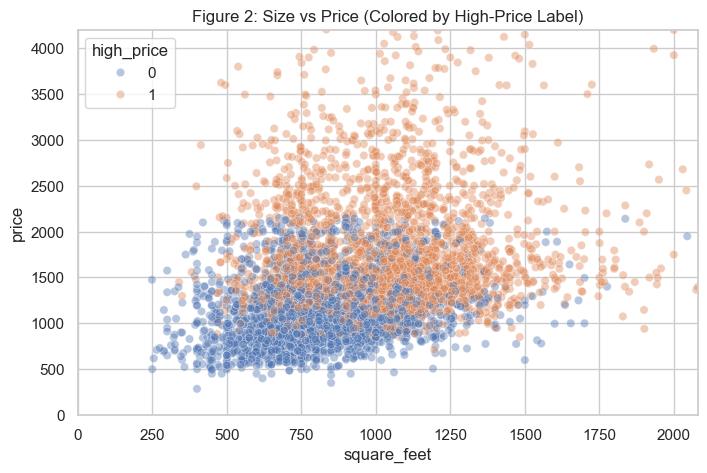

In [10]:
sample_df = df_subset.sample(n=min(5000, len(df_subset)), random_state=123)

sns.scatterplot(
    data=sample_df,
    x="square_feet",
    y="price",
    hue="high_price",
    alpha=0.4
)
plt.xlim(0, sample_df["square_feet"].quantile(0.99))
plt.ylim(0, sample_df["price"].quantile(0.99))
plt.title("Figure 2: Size vs Price (Colored by High-Price Label)")
plt.show()


# Modeling: Logistic Regression Classifier

We predict `high_price` using:

**Numeric features**
- square_feet  
- bathrooms  

**Categorical features**
- bedrooms  
- state  
- pets_allowed  
- fee  
- has_photo  

We use a train-test split and a preprocessing pipeline.


In [11]:
numeric_features = ["square_feet", "bathrooms"]
categorical_features = ["bedrooms", "state", "pets_allowed", "fee", "has_photo"]

model_df = df_subset[numeric_features + categorical_features + ["high_price"]].copy()

X = model_df[numeric_features + categorical_features]
y = model_df["high_price"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=123
)

(len(X_train), len(X_test))


(28560, 7140)

In [12]:
numeric_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

model = Pipeline(
    steps=[
        ("preprocessing", preprocessor),
        ("classifier", LogisticRegression(max_iter=1000))
    ]
)

model.fit(X_train, y_train)


/Users/shanzekhemani/miniforge3/envs/Group_26/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,steps,"[('preprocessing', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [13]:
y_pred = model.predict(X_test)

metrics = {
    "Accuracy": accuracy_score(y_test, y_pred),
    "Precision": precision_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1-score": f1_score(y_test, y_pred)
}

pd.DataFrame(metrics, index=["Logistic Regression"])


,Accuracy,Precision,Recall,F1-score
Logistic Regression,0.705182,0.726898,0.677269,0.701207


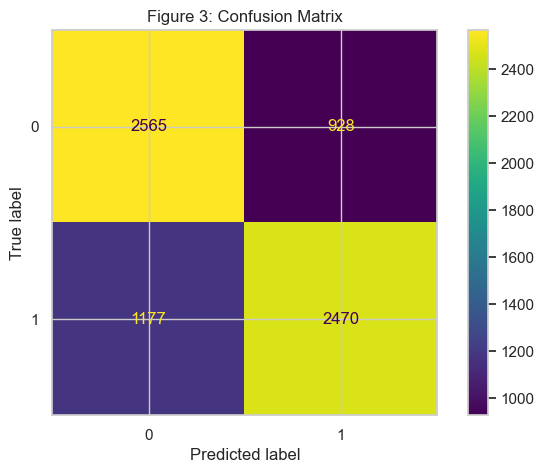

In [14]:
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title("Figure 3: Confusion Matrix")
plt.show()


# Discussion

## Summary of Findings

The logistic regression classifier performed reasonably well in predicting whether an apartment is high-priced relative to its state’s median rental price. Our logistic regression model achieved an accuracy of approximately 0.7, indicating that the model correctly classified 70% of apartment listings as either high-priced or not relative to their state's median rent. The model has a precision score of 0.715 which means the model was correct about 71% of the time when predicting an apartment to be high-priced. The recall score of approximately 0.660 shows the model was able to correctly identify about 66% of actually high-priced listings. Combined, these values resulted in a F1-score of 0.686. 

- Overall, these metrics suggest that the model provides a reasonably balanced performance, though there is room for improvement in correctly identifying all high-priced apartments.

## Analysis

The model performed well when identifying low-priced listings as indicated by the large number of true negatives (2,893). However, it was slightly less successful at identifying high-priced listings misclassifying 1,323 of them as not high-priced when they in fact were. These results align reasonably well with our expectations. We anticipated that apartment prices would vary across the country and the model's high precision of 0.72 suggests that it is usually correct when predicting a listing as high-priced, supporting the idea that certain features contribute meaningfully to the classification. The F1-score of ~0.69 indicates that the model is not overfitting to one class and maintains a balanced trade-off between identifying high-priced listings and avoiding false positives. 

Overall, the results suggest that rental price classification at the state level is predictable to a moderate degree, but not with perfect accuracy. This is likely due to the variability of housing markets across the country. The model performs as expected for a logistic regression approach and provides a useful baseline for predicting whether a listing is high-priced relative to its state’s median rent. 

## Limitations and Future Work
A key limitation of this analysis is that logistic regression may be too simple to capture the full complexity of rental markets, which vary widely across and within states. The model's moderate accuracy (0.70) and recall (0.66) indicate that many high priced listings remain misclassified, suggesting that important predictive features were not included.

Future work could expand this analysis by incorporating more advanced models such as random forests, as well as extracting additional insights through NLP features derived from apartment descriptions. It may also be valuable to explore state by state differences in greater depth and to perform regression modelling to predict exact prices rather than broader categories. Further improvements could come from adding location specific features like the neighbourhood characteristics, building age, or available amenities which may contribute more meaningfully to overall model performance.


# References

1. Investopedia. (2023). Gen Z is having more trouble affording a home — How some are achieving homeownership. https://www.investopedia.com/gen-z-is-having-more-trouble-affording-a-home-how-some-are-achieving-homeownership-11826137

2. Newsweek. (2023). Gen Z is renting, not buying: What it means for the country’s future. https://www.newsweek.com/gen-z-renting-not-buying-what-means-country-future-2120726

3. PR Newswire. (2023). Top 10 states to which Gen Zers are moving and the states they are leaving. https://www.prnewswire.com/news-releases/top-10-states-to-which-gen-zers-are-moving-and-the-states-they-are-leaving-302058380.html

4. Starmer, J. (n.d.). Classification metrics educational videos [YouTube channel]. StatQuest. https://www.youtube.com/user/joshstarmer

5. Scikit-Learn. (n.d.). Logistic regression & preprocessing. https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

6. UCI Machine Learning Repository. (n.d.). Apartment for rent classified dataset. https://archive.ics.uci.edu/ml/datasets/Apartment+for+Rent+Classified